In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time
import copy
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = 'data/'

In [3]:
os.listdir(path)

['train', 'valid']

In [4]:
os.listdir(f'{path}train')

['cats', 'dogs']

In [5]:
files = os.listdir(f'{path}valid/cats')[:5]

In [6]:
files

['cat.1001.jpg', 'cat.103.jpg', 'cat.1031.jpg', 'cat.1045.jpg', 'cat.1047.jpg']

In [7]:
from PIL import Image
image = Image.open(f'{path}valid/cats/{files[1]}')
image.show()

#### Data augmentation

In [8]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [9]:
image_dataset = {
    x: ImageFolder(os.path.join(path, x),transform[x]) 
                  for x in ['train', 'valid']
}

dataloaders = {}

dataloaders['train'] = DataLoader(image_dataset['train'], batch_size=4,
                                          shuffle=True, num_workers=0)

dataloaders['valid'] = DataLoader(image_dataset['valid'], batch_size=4,
                                         shuffle=False, num_workers=0)

dataset_sizes = {
    x: len(image_dataset[x]) 
                 for x in ['train', 'valid']
}

class_names = image_dataset['train'].classes
print(class_names)

['cats', 'dogs']


In [10]:
def inverse_transform(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

In [11]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

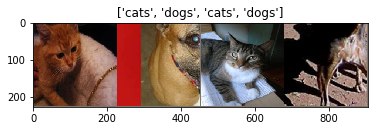

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

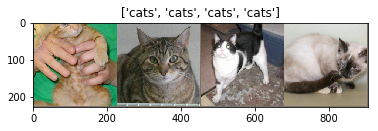

In [13]:
inputs, classes = next(iter(dataloaders['valid']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Create Model

In [14]:
resnet = models.resnet18(pretrained=True)

In [15]:
# num_features in fully connected layer
num_features = resnet.fc.in_features
num_features

512

#### Define full connected layer with to output category

In [16]:
resnet.fc = torch.nn.Linear(num_features, 2)

In [17]:
learning_rate = 1e-4
momentum = .9
step_size = 5

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, momentum=momentum)

#### Decay rate

In [19]:
lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size)

In [20]:
# check if cuda is available
if torch.cuda.is_available():
    model_resnet18 = model_resnet18.cuda()
    criterion = criterion.cuda()

#### Training model

In [21]:
def train(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
model = train(resnet, criterion, optimizer, lr_scheduler, dataloaders, 2)

Epoch 1/2
----------
train Loss: 0.4359 Acc: 0.7933
valid Loss: 0.1034 Acc: 0.9719

Epoch 2/2
----------
train Loss: 0.3187 Acc: 0.8654
valid Loss: 0.0778 Acc: 0.9749

Training complete in 93m 54s
Best val Acc: 0.974950


In [23]:
def visualize_model(model, num_images=6):
    
    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(dataloaders['valid']):
        
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, int(num_images/2), images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=8)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)

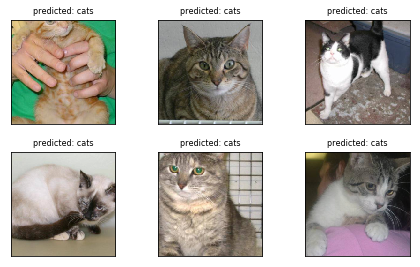

In [24]:
visualize_model(model)